# Grid2Op with Deep SARSA

## Import the necessary software libraries:

In [1]:
import grid2op
import random
import copy
import gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from typing import Callable
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm

from grid2op.gym_compat import GymEnv, BoxGymObsSpace, DiscreteActSpace
from gym import Env
from gym.utils.env_checker import check_env
try:
    from lightsim2grid import LightSimBackend
    bk_cls = LightSimBackend
except ImportError as exc:
    print(f"Error: {exc} when importing faster LightSimBackend")
    from grid2op.Backend import PandaPowerBackend
    bk_cls = PandaPowerBackend
    
from utils import plot_cost_to_go, plot_max_q, test_agent, plot_stats, seed_everything    
%matplotlib notebook

/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/usr/local/Caskroom/miniconda/base/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


## Create and prepare the environment

### Create the environment & Convert into Gym Compatible 

In [2]:
env_name = "rte_case14_realistic"
#env = grid2op.make(env_name, test=True, backend=bk_cls()
env = grid2op.make(env_name)
gym_env = GymEnv(env)

gym_env.observation_space = BoxGymObsSpace(env.observation_space, attr_to_keep=["rho"])
gym_env.action_space = DiscreteActSpace(env.action_space, attr_to_keep=["set_bus" , "set_line_status_simple"])

In [3]:
state_dims = gym_env.observation_space.shape[0]
num_actions = gym_env.action_space.n

print(f'state_dims = {state_dims}, num_actions = {num_actions}')

state_dims = 20, num_actions = 191


### Prepare the environment to work with PyTorch

In [4]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
    
    def reset(self):
        state = self.env.reset()
        return torch.from_numpy(state).unsqueeze(dim=0).float()
    
    def step(self, action):
        action = action.item()
        next_state, reward, done, info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1, -1).float()
        done = torch.tensor(done).view(1, -1)
        return next_state, reward, done, info

In [5]:
env = PreprocessEnv(gym_env)

In [6]:
state = env.reset()
action = torch.tensor(0)
next_state, reward, done, _ = env.step(action)
print(f'state = {state}')
print(f'next_state = {next_state}, reward = {reward}, done = {done}')

state = tensor([[0.4576, 0.3607, 0.3012, 0.3975, 0.7524, 0.1474, 0.3862, 0.4215, 0.5867,
         0.9132, 0.1706, 0.5156, 0.4409, 0.2343, 0.4323, 0.2747, 0.2148, 0.4933,
         0.2775, 0.1768]])
next_state = tensor([[0.4499, 0.3584, 0.3089, 0.3958, 0.7512, 0.1424, 0.3810, 0.4209, 0.5895,
         0.9167, 0.1566, 0.5186, 0.4400, 0.2340, 0.4305, 0.2745, 0.2151, 0.4952,
         0.2769, 0.1773]]), reward = tensor([[88.2405]]), done = tensor([[False]])


### Create the Q-Network: $\hat q(s,a| \theta)$

In [7]:
'''
q_network = nn.Sequential(
    # nn.Linear  state * W + b
    nn.Linear(state_dims, 128),
    # nn.ReLU  max(0, state * W + b)
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions))
'''    

'\nq_network = nn.Sequential(\n    # nn.Linear  state * W + b\n    nn.Linear(state_dims, 128),\n    # nn.ReLU  max(0, state * W + b)\n    nn.ReLU(),\n    nn.Linear(128, 64),\n    nn.ReLU(),\n    nn.Linear(64, num_actions))\n'

In [8]:
'''
q_network = nn.Sequential(
    # nn.Linear  state * W + b
    nn.Linear(state_dims, 128),
    # nn.ReLU  max(0, state * W + b)
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, num_actions))
'''

'\nq_network = nn.Sequential(\n    # nn.Linear  state * W + b\n    nn.Linear(state_dims, 128),\n    # nn.ReLU  max(0, state * W + b)\n    nn.ReLU(),\n    nn.Linear(128, 64),\n    nn.ReLU(),\n    nn.Linear(64, num_actions))\n'

In [9]:
q_network = nn.Sequential(
    # nn.Linear  state * W + b
    nn.Linear(state_dims, 300),
    # nn.ReLU  max(0, state * W + b)
    nn.ReLU(),
    nn.Linear(300, 250),
    nn.ReLU(),
    nn.Linear(250, num_actions))

In [10]:
# in the video they have 2 state dimension and 3 actions, so should we need to add more hidden layers in q-network?
q_network

Sequential(
  (0): Linear(in_features=20, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=250, bias=True)
  (3): ReLU()
  (4): Linear(in_features=250, out_features=191, bias=True)
)

### Create the target Q-Network: $\hat q(s, a|\theta_{targ})$

In [11]:
target_q_network = copy.deepcopy(q_network).eval()
print(target_q_network)

Sequential(
  (0): Linear(in_features=20, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=250, bias=True)
  (3): ReLU()
  (4): Linear(in_features=250, out_features=191, bias=True)
)


### Create the $\epsilon$-greedy policy: $\pi(s)$
If torch.rand(1) is lower than epsilon, a random action is chosen. Otherwise, we produce the q-value estimates using the neural network and then we choose the highest estimated value. 

In [12]:
def policy(state, epsilon=0.):
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

In [13]:
#plot_cost_to_go(gym_env, q_network, xlabel='Car Position', ylabel='Velocity')

In [14]:
class ReplayMemory:

    # capacity: the maximum number of transitions that this memory can store
    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    # insert [s, a, r, s'] = [state, action, reward, next_state]
    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity
    
    # sample [[s, a, r, s'], [s, a, r, s']]
    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        
        # [[s, a, r, s'], [s, a, r, s'], [s, a, r, s']] - > [[s, s, s], [a, a, a], [r, r, r], [s', s', s']]
        batch = zip(*batch)
        
        # output: number of element x dimension = 3 ([s, s, s]) x 20 
        return [torch.cat(items) for items in batch]
    
    # can_sample -> True/False
    # it will return true if the memory has enough as they transitions to begin drawing batches from it
    def can_sample(self, batch_size):
        #print(f'memory_size = {len(self.memory)}, batch_size = {batch_size * 10}')
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

In [15]:
def deep_sarsa(q_network, policy, episodes, alpha=0.001, batch_size=32, gamma=0.99, epsilon=0.):
    optim = AdamW(q_network.parameters(), lr=alpha)
    memory = ReplayMemory()
    stats = {'MSE Loss': [], 'Returns': []}
    
    index = 0
    for episode in tqdm(range(1, episodes + 1)):
        state = env.reset()
        done = False
        ep_return = 0.
        
        while not done:
            action = policy(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            memory.insert([state, action, reward, done, next_state])
            index += 1
            #print(f'index = {index}')
            
            if memory.can_sample(batch_size):
                state_b, action_b, reward_b, done_b, next_state_b = memory.sample(batch_size)
                qsa_b = q_network(state_b).gather(1, action_b)
                next_action_b = policy(next_state_b, epsilon)
                next_qsa_b = target_q_network(next_state_b).gather(1, next_action_b)
                target_b = reward_b + ~done_b * gamma * next_qsa_b
                
                loss = F.mse_loss(qsa_b, target_b)
                q_network.zero_grad()
                loss.backward()
                optim.step()
                
                stats['MSE Loss'].append(loss.item())
            
            state = next_state
            ep_return += reward.item()
        
        stats['Returns'].append(ep_return)
        
        if episode % 10 == 0:
            target_q_network.load_state_dict(q_network.state_dict())
        
    return stats

In [16]:
print(policy)

<function policy at 0x7fe68200b3a0>


In [17]:
stats = deep_sarsa(q_network, policy, 50, alpha=0.01, epsilon=0.05)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.44it/s]


In [18]:
print(stats)

{'MSE Loss': [8947.03515625, 9171.6845703125, 8418.9296875, 8284.8662109375, 7376.078125, 5254.91650390625, 3298.79345703125, 2423.561279296875, 2320.38818359375, 1537.3095703125, 2075.43017578125, 2705.216552734375, 2927.470458984375, 700.9454345703125, 1612.9376220703125, 1852.143798828125, 1035.1055908203125, 1896.6207275390625, 1657.5394287109375, 2192.199462890625, 1985.4049072265625, 1247.9117431640625, 1372.268310546875, 547.5291137695312, 956.9381713867188, 108.72911834716797, 1201.7554931640625, 249.1090850830078, 956.5037841796875, 1961.9708251953125, 1292.304931640625, 590.0346069335938, 517.4238891601562, 701.1820068359375, 506.9068298339844, 376.52923583984375, 522.4796752929688, 972.5707397460938, 1047.9503173828125, 741.822021484375, 700.5338745117188, 705.8017578125, 437.02984619140625, 527.05029296875, 1011.2752075195312, 1453.4903564453125, 103.73625946044922, 961.2601928710938, 1102.760009765625, 909.9424438476562, 822.2369384765625, 1039.4464111328125, 909.379394531

## Show results

### Plot execution stats

<IPython.core.display.Javascript object>


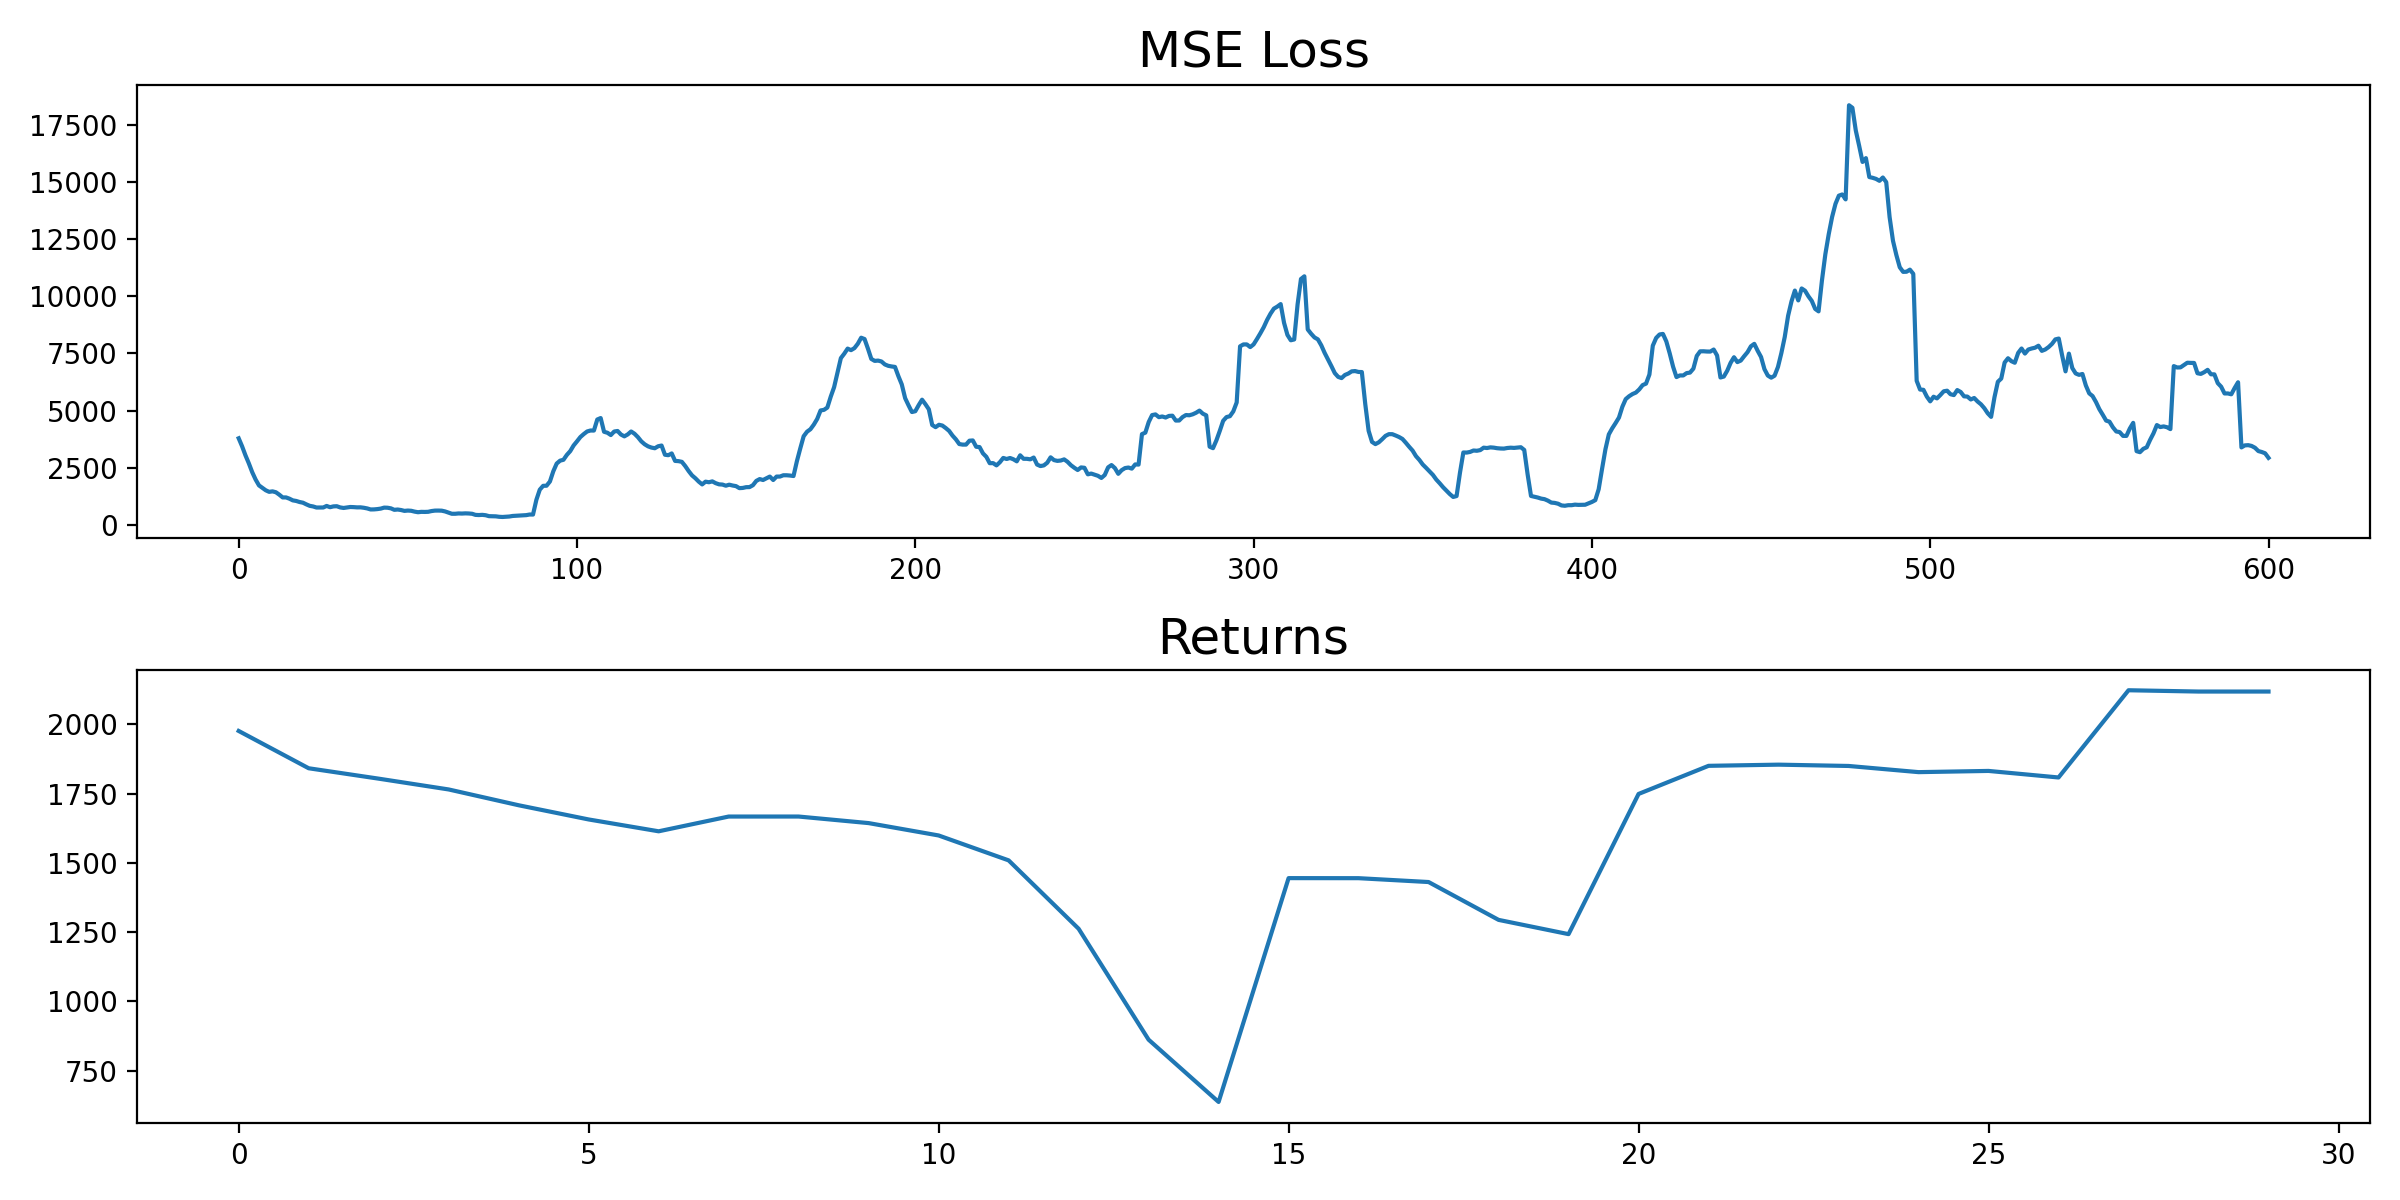

In [19]:
plot_stats(stats)

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

In [20]:
#plot_cost_to_go(gym_env, q_network, xlabel='Car Position', ylabel='Velocity')

### Show resulting policy: $\pi(s)$

In [21]:
#plot_max_q(gym_env, q_network, xlabel='Car Position', ylabel='Velocity', action_labels=['Back', 'Do nothing', 'Forward'])

### Test the resulting agent

In [22]:
def test_agent(env: gym.Env, policy: Callable, episodes: int = 10) -> None:
    #plt.figure(figsize=(8, 8))
    for episode in range(episodes):
        state = env.reset()
        done = False
        #img = plt.imshow(env.render(mode='rgb_array'))
        while not done:
            p = policy(state)
            if isinstance(p, np.ndarray):
                action = np.random.choice(4, p=p)
            else:
                action = p
            next_state, _, done, _ = env.step(action)
            #img.set_data(env.render(mode='rgb_array'))
            #plt.axis('off')
            #display.display(plt.gcf())
            #display.clear_output(wait=True)
            state = next_state

In [23]:
#test_agent(gym_env, q_network, episodes=2)